In [86]:
import torch 
import torchvision
import numpy 
import torch.nn as nn
import torch.optim as optim
import tqdm

In [87]:
from torch.autograd import Variable 

In [88]:
from torch.utils.data import DataLoader,Dataset
from torchvision.models import resnet50
import torchvision.transforms as transforms

In [89]:
import numpy as np

In [90]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Transformations
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
trainset  = CIFAR10(root='./cifar-10/', train=True , download=True)#, transform = transform_with_aug)
testset   = CIFAR10(root='./cifar-10/', train=False, download=True)#, transform = transform_no_aug)
classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
x_train  = trainset.data
x_test   = testset.data
y_train  = trainset.targets
y_test   = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    
    def __init__(self, datasets, transformFunc = transform_no_aug):
        super(DatasetMaker,self).__init__()
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

# ================== Usage ================== #

# Let's choose plane(class 3 of CIFAR) and dogs (class 5 of CIFAR) as trainset/testset
plane_dog_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']), get_class_i(x_train, y_train, classDict['dog'])],
        transform_with_aug
    )
plane_dog_testset  = \
    DatasetMaker(
        [get_class_i(x_test , y_test , classDict['plane']), get_class_i(x_test , y_test , classDict['dog'])],
        transform_no_aug
    )

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
#trainsetLoader   = DataLoader(cat_dog_trainset, batch_size=64, shuffle=True , **kwargs)
#testsetLoader    = DataLoader(cat_dog_testset , batch_size=64, shuffle=False, **kwargs)

trainsetLoader   = DataLoader(plane_dog_trainset, batch_size=1, shuffle=True , **kwargs)
testsetLoader    = DataLoader(plane_dog_testset , batch_size=1, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [91]:
len(trainsetLoader)
#len(testsetLoader)

10000

In [92]:
device='cuda:0'

In [93]:
base = resnet50(pretrained=True)

In [94]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity,self).__init__()

  def forward(self,x):
    return x

In [95]:
base.fc = Identity()

In [96]:
for param in base.parameters():
    param.requires_grad = False

In [97]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()
base.apply(deactivate_batchnorm)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [98]:
x_train=[]
y_train =[]
base.to(device)
for i,(inputs,targets) in enumerate(trainsetLoader):
    inputs = Variable(inputs)
    inputs = inputs.to(device)
    targets = Variable(targets)
    targets = targets.to(device)
    out = base(inputs)
    out =out.view(-1)
    out = out.cpu().data.numpy()
    x_train.append(out)
    y_train.append(targets)

In [99]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [100]:
x_train.shape

(10000, 2048)

In [101]:
y_train.shape

(10000,)

In [108]:
y_train = y_train.astype('float')

In [112]:
y_test = y_test.astype('float')

In [102]:
x_test=[]
y_test =[]
base.to(device)
for i,(inputs,targets) in enumerate(testsetLoader ):
    inputs = Variable(inputs)
    inputs = inputs.to(device)
    targets = Variable(targets)
    targets = targets.to(device)
    out = base(inputs)
    out =out.view(-1)
    out = out.cpu().data.numpy()

    x_test.append(out)
    y_test.append(targets)

In [103]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [104]:
x_test.shape

(2000, 2048)

In [105]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [132]:
classifier = svm.SVC(kernel='linear', probability=True)
probas_ = classifier.fit(x_train, y_train)

In [133]:
pred = probas_.predict(x_test)

In [134]:
accuracy_score(y_test, pred)

0.9125

In [135]:
def create_conf_matrix(expected, predicted, n_classes):
    m = [[0] * n_classes for i in range(n_classes)]
    for pred, exp in zip(predicted, expected):
        m[pred][exp] += 1
    return m

In [136]:
mtr = create_conf_matrix(y_test.astype('int'),pred.astype('int'),2)

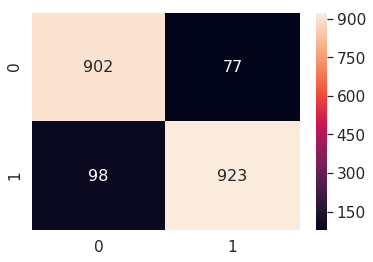

In [137]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(mtr, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.5g') # font size

plt.show()

In [149]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [145]:
y_score1 = probas_.predict_proba(x_test)[:,1]

In [147]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [150]:
print('roc_auc_score for SVM: ', roc_auc_score(y_test, y_score1))

roc_auc_score for SVM:  0.970165


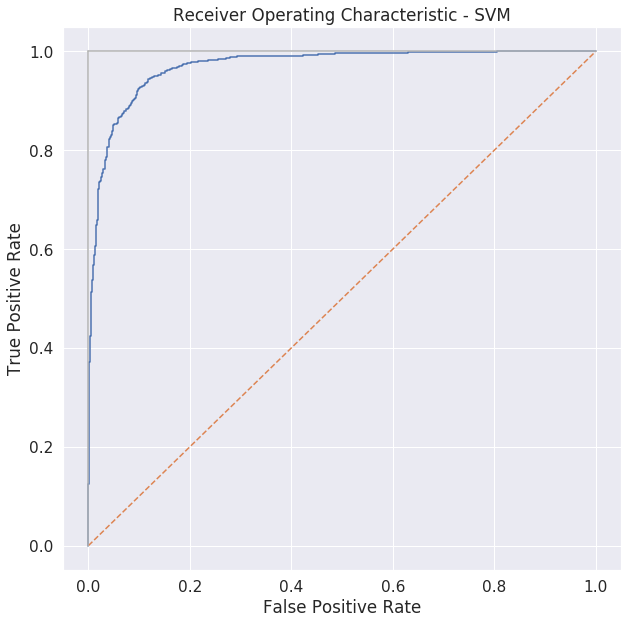

In [152]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()